In [1]:
from leader_data import *
home_dir = os.path.abspath("..")  # Move up to the home directory
sys.path.append(home_dir)
from frengression import *
device = torch.device('cpu')

import numpy as np
import pandas as pd
import pickle
import os
from tqdm import tqdm
import torch.nn as nn
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

np.random.seed(42)


read data

In [2]:
df_bsl_read=generate_bsl()
df_bsl_read.dropna(inplace=True)
df_outcome=generate_outcome()
df_outcome

df_Y_read = df_outcome[['USUBJID'] + [f'Y{i}' for i in range(1, 11)]]
df_I = df_outcome[['USUBJID'] + [f'I{i}' for i in range(1, 11)]]
df_D = df_outcome[['USUBJID'] + [f'D{i}' for i in range(1, 11)]]
df_egfr, df_hba1c, df_bmi = generate_longi_cov()
df_Y_read

,USUBJID,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10
1,EX2211-3748/5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EX2211-3748/9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EX2211-3748/16,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
4,EX2211-3748/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,EX2211-3748/62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9336,EX2211-3748/99915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9337,EX2211-3748/99921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9338,EX2211-3748/99929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9339,EX2211-3748/99971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# number of events happened
ones_count = (df_Y_read.drop(columns=['USUBJID']) == 1).sum().sum()
ones_count

1302

In [4]:
df_hba1c

,USUBJID,0,12,18,24,3,30,36,42,48,54,6,60,1,61
1,EX2211-3748/10012,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,NaN,NaN
2,EX2211-3748/10023,7.6,6.0,6.3,6.0,6.3,6.1,6.4,6.8,6.5,6.5,6.3,7.3,NaN,NaN
3,EX2211-3748/10028,9.9,9.5,7.9,9.6,8.4,9.2,9.9,9.6,9.6,9.6,8.6,9.6,NaN,NaN
4,EX2211-3748/10034,9.6,9.6,9.5,9.3,9.6,7.0,6.0,6.0,6.0,6.0,10.9,6.3,NaN,NaN
5,EX2211-3748/10050,7.5,7.8,8.9,8.7,8.0,8.5,8.1,8.1,8.1,8.1,6.3,9.6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,EX2211-3748/99915,7.1,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,NaN,NaN
9337,EX2211-3748/99921,8.6,6.5,6.6,6.6,6.0,6.5,7.0,7.0,7.0,7.0,6.1,6.3,NaN,NaN
9338,EX2211-3748/99929,7.3,7.0,7.0,7.0,6.9,7.0,7.0,7.0,7.0,7.0,6.9,7.0,NaN,NaN
9339,EX2211-3748/99971,10.5,8.3,10.0,11.1,9.8,10.0,9.4,9.7,9.7,9.7,9.7,10.7,8.9,NaN


In [5]:
df_bmi

,USUBJID,0,12,24,36,48,6,60
1,EX2211-3748/10012,31.6,31.6,31.6,31.6,31.6,31.6,31.6
2,EX2211-3748/10023,39.0,37.3,37.3,38.2,39.5,38.5,39.9
3,EX2211-3748/10028,30.8,30.7,30.4,29.3,29.3,30.6,30.1
4,EX2211-3748/10034,41.4,42.6,41.7,30.4,30.4,41.9,29.5
5,EX2211-3748/10050,50.8,48.8,45.8,45.2,45.2,45.1,44.7
...,...,...,...,...,...,...,...,...
9327,EX2211-3748/99915,37.5,37.5,37.5,37.5,37.5,37.5,37.5
9328,EX2211-3748/99921,33.7,31.4,33.3,33.4,33.4,31.1,33.1
9329,EX2211-3748/99929,27.0,27.8,27.8,27.8,27.8,28.4,27.8
9330,EX2211-3748/99971,28.0,31.3,29.9,29.7,29.7,29.7,29.6


In [6]:
df_egfr

,USUBJID,0,12,24,36,48,6,60,61,30,42,1,18,3,54
1,EX2211-3748/10012,96.7,96.7,96.7,96.7,96.7,96.7,96.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EX2211-3748/10023,84.3,89.5,91.2,86.8,84.3,91.2,84.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EX2211-3748/10028,84.4,77.1,70.0,88.5,88.5,78.3,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX2211-3748/10034,75.5,91.0,83.3,78.0,78.0,79.2,92.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,EX2211-3748/10050,75.7,90.0,59.0,42.3,42.3,100.6,65.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,EX2211-3748/99915,79.8,79.8,79.8,79.8,79.8,79.8,79.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9337,EX2211-3748/99921,93.1,94.2,93.6,81.4,81.4,96.9,77.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9338,EX2211-3748/99929,105.1,107.0,107.0,107.0,107.0,93.6,107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9339,EX2211-3748/99971,103.4,90.7,91.2,95.0,95.0,85.2,90.7,NaN,NaN,NaN,95.6,NaN,NaN,NaN


The longitudinal features are processed with these rules:
1. As hba1c has been measured several times, we use it as the benchmark for marking the records. However, we still discard month = 1 and month = 61 as there are not that many
2. Since egfr and bmi are measured less frequently, we impute the missing values using the observations in the previous visit time.
3. The simulated data will be evaluated by masking up intervals that the egfr and bmi are not recorded.

Also, we standardize continuous variables in baseline covariates and time varying covariates.

## pre-process data

In [94]:
import pandas as pd
import numpy as np
import torch
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# ------------------------- Load Your Data -------------------------
df_z1 = deepcopy(df_hba1c)   # longitudinal covariate z1
df_z2 = deepcopy(df_egfr)    # longitudinal covariate z2
df_z3 = deepcopy(df_bmi)     # longitudinal covariate z3
df_bsl = deepcopy(df_bsl_read)    # baseline covariates
df_Y = deepcopy(df_Y_read)        # outcome
df_bsl.dropna(inplace=True)
df_bsl.drop(df_bsl[(df_bsl['TRIG1BL'] > 8) | (df_bsl['CREATBL'] > 160)].index, inplace=True)



# --------------------- Process df_Y (Outcome) ---------------------
# Ensure Y0 exists and select Y0 to Y10.
if 'Y0' not in df_Y.columns:
    df_Y.insert(1, 'Y0', 0.0)
df_Y = df_Y[['USUBJID'] + [f'Y{i}' for i in range(0, 11)]]

# (These are the actual numeric time values corresponding to Y0 ... Y10.)
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]

def process_longitudinal(df, time_points):
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points if str(tp) in df.columns]].copy()
    for tp in time_points:
        col = str(tp)
        if col not in df.columns:
            df.loc[:, col] = np.nan
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points]]

    df['na_count'] = df.isna().sum(axis=1)
    df = df.loc[df['na_count'] <= 5].drop(columns='na_count').reset_index(drop=True)

    for idx in range(len(df)):
        for t_idx, t in enumerate(time_points):
            col = str(t)
            if pd.isna(df.loc[idx, col]):
                for prev_t in reversed(time_points[:t_idx]):
                    prev_col = str(prev_t)
                    if not pd.isna(df.loc[idx, prev_col]):
                        df.loc[idx, col] = df.loc[idx, prev_col]
                        break

    return df

# ------------- Process and Clean z1, z2, z3 ----------------
df_z1_clean = process_longitudinal(df_z1, time_points)
df_z2_clean = process_longitudinal(df_z2, time_points)
df_z3_clean = process_longitudinal(df_z3, time_points)


df_z1_clean = df_z1_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z2_clean = df_z2_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z3_clean = df_z3_clean.dropna(axis=0, how='any').reset_index(drop=True)

# ------------ Align All by Intersection of USUBJID -------------
common_ids = (set(df_Y['USUBJID']) 
              & set(df_z1_clean['USUBJID']) 
              & set(df_z2_clean['USUBJID']) 
              & set(df_z3_clean['USUBJID']) 
              & set(df_bsl['USUBJID']))
df_Y = df_Y[df_Y['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z1_clean = df_z1_clean[df_z1_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z2_clean = df_z2_clean[df_z2_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z3_clean = df_z3_clean[df_z3_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_bsl = df_bsl[df_bsl['USUBJID'].isin(common_ids)].reset_index(drop=True)


for D in (df_Y, df_z1_clean, df_z2_clean, df_z3_clean, df_bsl):
    D.sort_values('USUBJID', inplace=True)
    D.reset_index(drop=True, inplace=True)

cols = [str(tp) for tp in time_points]

for df in (df_z1_clean, df_z2_clean, df_z3_clean):
    # compute per-column mean & std, skipping NaNs
    means = df[cols].mean(skipna=True)
    stds  = df[cols].std(skipna=True)

    # subtract mean, divide by std; NaNs remain NaN
    df[cols] = (df[cols] - means) / stds

# ----------------- Build the Z torch tensor (longitudinal) ----------------------

Z_list = []
for idx in range(len(df_z1_clean)):
    z1_vals = df_z1_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z2_vals = df_z2_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z3_vals = df_z3_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values

    Z_subj = np.column_stack([z1_vals, z2_vals, z3_vals]).reshape(-1)
    Z_list.append(Z_subj.astype(np.float32))

z_tensor = torch.tensor(np.vstack(Z_list), dtype=torch.float32)  # Shape (n_subjects, len(time_points))
# ----------------- Build the X tensor (ARM repeated over time) -------------------
# Pull ARM values from df_bsl; assume 'ARM' is a column.
arm_values = df_bsl['ARM'].astype(float).values  # shape (n_subjects,)
x_tensor = torch.tensor(np.repeat(arm_values[:, np.newaxis], len(time_points), axis=1), dtype=torch.int32)
# ------------------ Build the y torch tensor ----------------------
y_cols = [f'Y{i}' for i in range(0, 11)]
y_np = df_Y[y_cols].astype(float).values  # Ensure it's float so that NaN is preserved
y_tensor = torch.tensor(y_np, dtype=torch.int32)
# ----------------- Build the S tensor (baseline features) -------------------
df_bsl_features = df_bsl.drop(columns=['USUBJID','ARM',  
    'RACE_AMERICAN.INDIAN.OR.ALASKA.NATIVE',
    'RACE_NATIVE.HAWAIIAN.OR.OTHER.PACIFIC.ISLANDER',
    'RACE_OTHER',
    'RACE_ASIAN',
    'RACE_BLACK.OR.AFRICAN.AMERICAN',"HBA1CBL","BMIBL", 'SMOKER_CURRENT.SMOKER',
    "STROKEFL",	
     'KIDFL',
      'MIFL',	
    # "STENFL",
    # #"AGE", 
    # "DIABDUR",
    #"HDL1BL",	"LDL1BL",	
    # "CHOL1BL",	
    #"TRIG1BL", 
    # "CREATBL"
    ])

binary_cols     = ['SEX_F', 'SMOKER_NEVER.SMOKED',"STENFL",'NEPSCRFL'] 
continuous_cols = [c for c in df_bsl_features.columns
                   if c not in binary_cols]

# 2. Scale the continuous ones to zero‑mean, unit‑variance
scaler = StandardScaler()
df_bsl_cont = pd.DataFrame(
    scaler.fit_transform(df_bsl[continuous_cols]),
    columns=continuous_cols,
    index=df_bsl.index
)

df_bsl_norm = pd.concat([df_bsl_features[binary_cols],df_bsl_cont], axis=1)

df_bsl_features = df_bsl_features.astype(float)
x_bsl_tensor = torch.tensor(df_bsl['ARM'].values, dtype=torch.int32).view(-1, 1)
# s_tensor = torch.tensor(df_bsl_features.values, dtype=torch.float32)
s_tensor = torch.tensor(df_bsl_norm.astype(float).values, dtype=torch.float32)

# ----------------- Check shape -------------------
print(f"s_tensor shape: {s_tensor.shape}")  # (n_subjects, num_baseline_features)
print(f"z_tensor shape: {z_tensor.shape}")  # (n_subjects, {len(time_points)}) 
print(f"x_tensor shape (ARM): {x_tensor.shape}")  # (n_subjects, 11)
print(f"y_tensor shape: {y_tensor.shape}")  # (n_subjects, 11)

# Optional: Sanity check USUBJID order alignment.
print(np.all(df_Y['USUBJID'].values == df_z1_clean['USUBJID'].values))
print(np.all(df_Y['USUBJID'].values == df_bsl['USUBJID'].values))
print(torch.isnan(y_tensor).any())  # Returns True if any NaN exists

# Optional: Count the number of 1's in a DataFrame.
# For example, to count total number of 1s in df_Y (excluding the USUBJID column):
ones_count = (df_Y.drop(columns=['USUBJID']) == 1).sum().sum()
print("Total number of 1s in df_Y:", ones_count)


s_tensor shape: torch.Size([8730, 11])
z_tensor shape: torch.Size([8730, 33])
x_tensor shape (ARM): torch.Size([8730, 11])
y_tensor shape: torch.Size([8730, 11])
True
True
tensor(False)
Total number of 1s in df_Y: 1168


In [95]:
p = s_tensor.shape[1]
print(f'number of covariates: {p}')
binary_intervention = True
torch.manual_seed(42)

number of covariates: 11


In [ ]:
# p = s_tensor.shape[1]
# print(f'number of covariates: {p}')
# binary_intervention = True
# torch.manual_seed(42)
# model_bsl = Frengression(x_bsl_tensor.shape[1], y_tensor.shape[1], s_tensor.shape[1], noise_dim=20, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention, z_binary_dims=4)
# model_bsl.train_xz(x_bsl_tensor, s_tensor, num_iters=15000, lr=1e-3, print_every_iter=1000)

number of covariates: 11
Epoch 1: loss 2.6306, loss1 2.7492, loss2 0.2373
Epoch 1000: loss 1.9317, loss1 3.8513, loss2 3.8391
Epoch 2000: loss 1.9257, loss1 3.8400, loss2 3.8287
Epoch 3000: loss 1.9315, loss1 3.8511, loss2 3.8391
Epoch 4000: loss 1.9375, loss1 3.8395, loss2 3.8040
Epoch 5000: loss 1.9299, loss1 3.8660, loss2 3.8723
Epoch 6000: loss 1.9283, loss1 3.8615, loss2 3.8664
Epoch 7000: loss 1.9224, loss1 3.8708, loss2 3.8968
Epoch 8000: loss 1.9286, loss1 3.8485, loss2 3.8398
Epoch 9000: loss 1.9292, loss1 3.8397, loss2 3.8210
Epoch 10000: loss 1.9281, loss1 3.8334, loss2 3.8107
Epoch 11000: loss 1.9317, loss1 3.8473, loss2 3.8312
Epoch 12000: loss 1.9315, loss1 3.8698, loss2 3.8767
Epoch 13000: loss 1.9325, loss1 3.8490, loss2 3.8332
Epoch 14000: loss 1.9321, loss1 3.8673, loss2 3.8704
Epoch 15000: loss 1.9235, loss1 3.8580, loss2 3.8690


In [9]:
model_bsl = torch.load("results/model_bsl.pt")

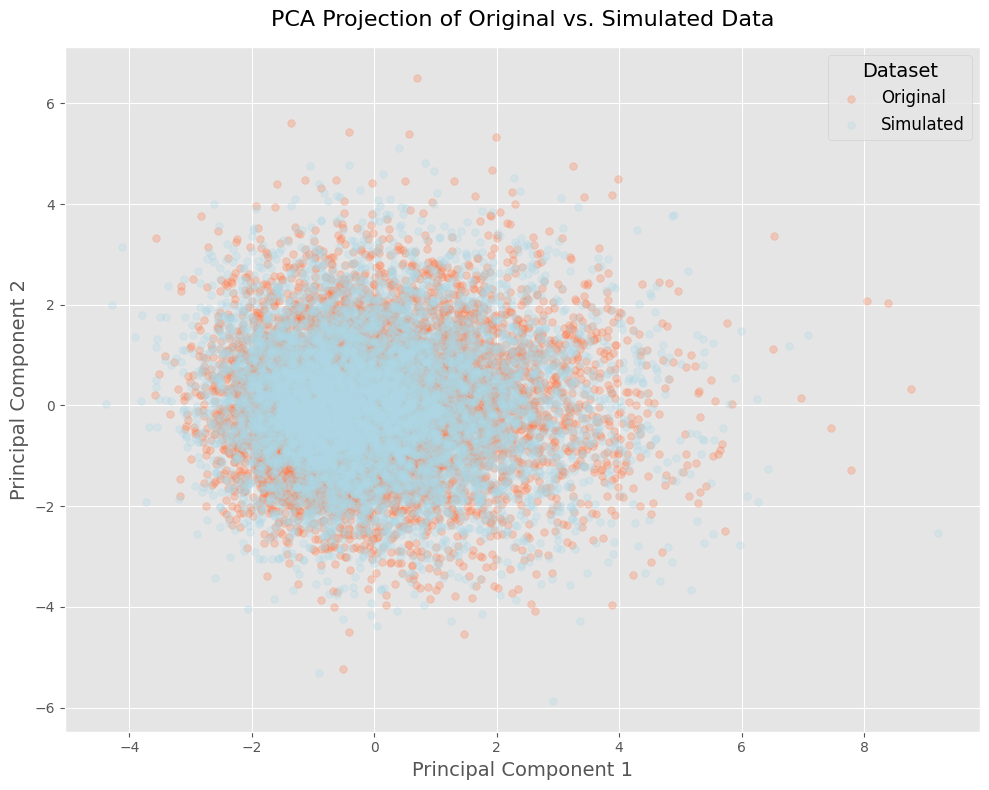

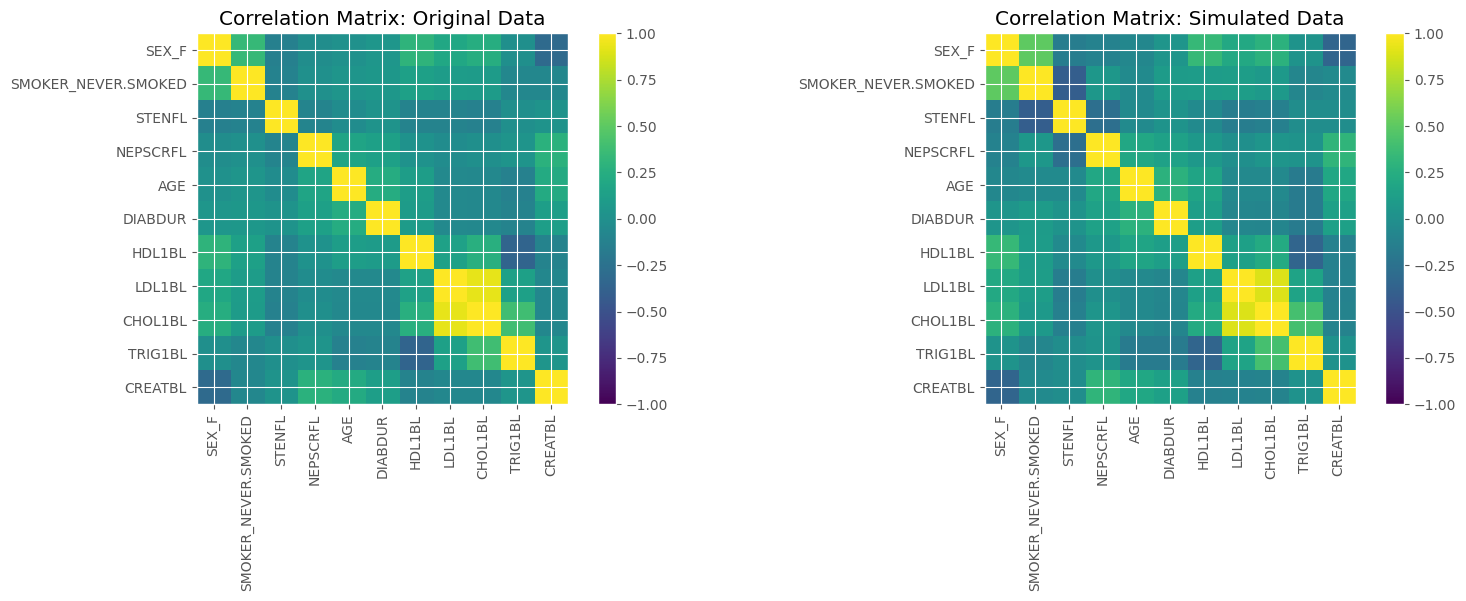

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      2619
           1       0.49      0.49      0.49      2619

    accuracy                           0.49      5238
   macro avg       0.49      0.49      0.49      5238
weighted avg       0.49      0.49      0.49      5238

Accuracy: 0.49
ROC AUC: 0.50


In [12]:
x,s_pred=model_bsl.sample_xz(sample_size=s_tensor.shape[0])

original_df = deepcopy(df_bsl_norm)
simulated_df = pd.DataFrame(s_pred.numpy())
simulated_df.columns = original_df.columns
original_df ['source'] = 'original'
simulated_df['source'] = 'simulated'
# original_df.drop(columns={'USUBJID'},inplace=True)
combined_df = pd.concat([original_df, simulated_df], ignore_index=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

original_df['source'] = 'Original'
simulated_df['source'] = 'Simulated'

combined_df = pd.concat([original_df, simulated_df], ignore_index=True)
features = combined_df.drop(columns='source')
labels = combined_df['source']

# --- PCA Transformation ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['source'] = labels.values

style = 'seaborn' if 'seaborn' in plt.style.available else 'ggplot'
plt.style.use(style)

fig, ax = plt.subplots(figsize=(10, 8))


colors = {'Original': 'coral', 'Simulated': 'lightblue'}

for group in pca_df['source'].unique():
    group_data = pca_df[pca_df['source'] == group]
    ax.scatter(group_data['PC1'], group_data['PC2'],
               s=30, alpha=0.3, label=group, color=colors[group])

ax.set_title('PCA Projection of Original vs. Simulated Data', fontsize=16, pad=15)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)

ax.legend(title='Dataset', fontsize=12, title_fontsize=14, loc='best')

plt.tight_layout()
plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# ---------------------------
# 1. Population Summary Comparison
# ---------------------------
# Compute mean values for each covariate
original_df.drop(columns={'source'},inplace=True)
simulated_df.drop(columns={'source'},inplace=True)
mean_original = original_df.mean()
mean_simulated = simulated_df.mean()

# Create a grouped bar chart comparing means
x = np.arange(len(mean_original))  # positions for each covariate
width = 0.35  # width of the bars

# plt.style.use('ggplot')  # Use a beautiful built-in style
# fig, ax = plt.subplots(figsize=(12, 6))
# rects1 = ax.bar(x - width/2, mean_original, width, label='Original')
# rects2 = ax.bar(x + width/2, mean_simulated, width, label='Simulated')

# ax.set_xticks(x)
# ax.set_xticklabels(original_df.columns, rotation=45, ha='right')
# ax.set_ylabel('Mean Value')
# ax.set_title('Comparison of Mean Values by Covariate')
# ax.legend()
# plt.tight_layout()
# plt.show()


corr_original = original_df.corr()
corr_simulated = simulated_df.corr()

# Create two heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap for original data
im0 = axes[0].imshow(corr_original, cmap='viridis', vmin=-1, vmax=1)
axes[0].set_title('Correlation Matrix: Original Data')
axes[0].set_xticks(np.arange(len(corr_original.columns)))
axes[0].set_xticklabels(corr_original.columns, rotation=90)
axes[0].set_yticks(np.arange(len(corr_original.columns)))
axes[0].set_yticklabels(corr_original.columns)
plt.colorbar(im0, ax=axes[0])

# Heatmap for simulated data
im1 = axes[1].imshow(corr_simulated, cmap='viridis', vmin=-1, vmax=1)
axes[1].set_title('Correlation Matrix: Simulated Data')
axes[1].set_xticks(np.arange(len(corr_simulated.columns)))
axes[1].set_xticklabels(corr_simulated.columns, rotation=90)
axes[1].set_yticks(np.arange(len(corr_simulated.columns)))
axes[1].set_yticklabels(corr_simulated.columns)
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


orig = original_df.copy()
sim = simulated_df.copy()

orig['label'] = 0
sim['label'] = 1

# Combine the datasets
combined_df = pd.concat([orig, sim], ignore_index=True)

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split into training and testing sets (stratified to maintain label balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Get predictions and predicted probabilities for AUC calculation
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC: {:.2f}".format(auc))

# If the two datasets are very similar, even a strong classifier should perform poorly
# (accuracy near 50% and AUC near 0.5), indicating that it is difficult to tell them apart.


In [16]:
# torch.save(model_bsl,"results/model_bsl.pt")
model_bsl=torch.load('results/model_bsl.pt')

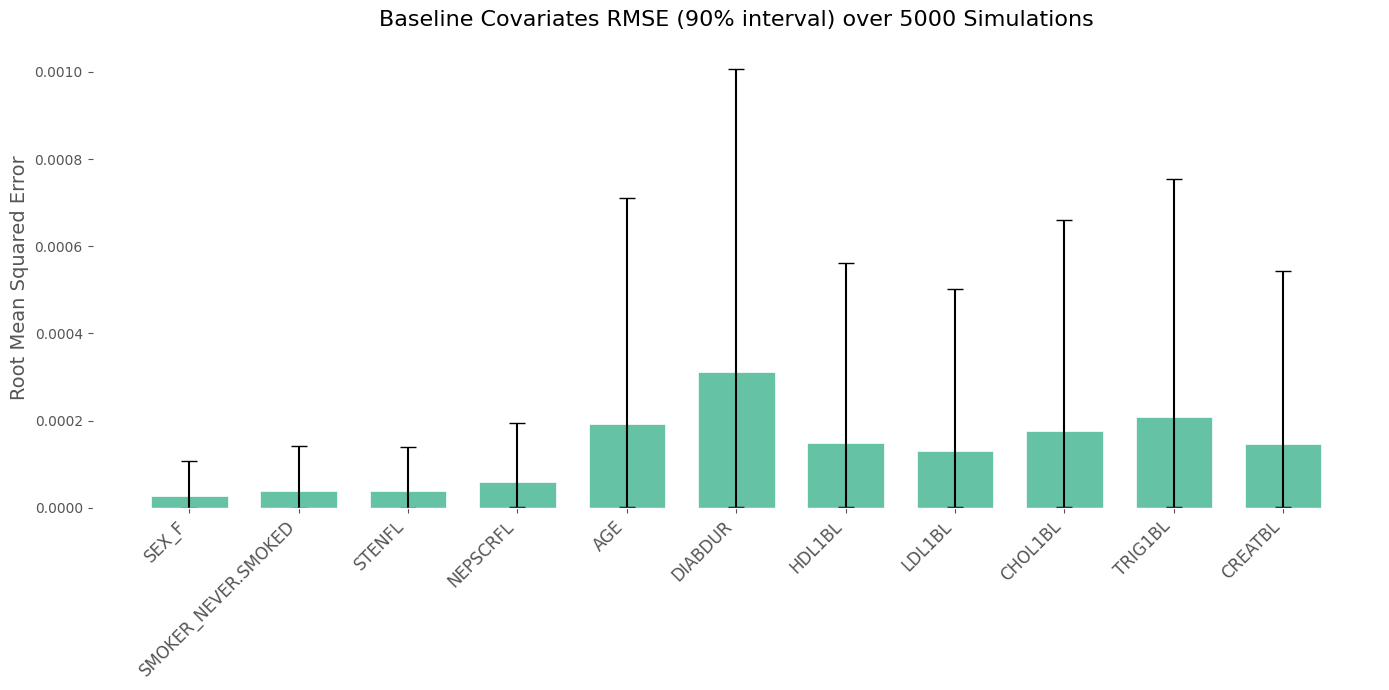

Accuracy:  μ=0.497, σ=0.007, [0.462–0.522]
AUC:       μ=0.496, σ=0.006, [0.470–0.520]


In [13]:

num_simulations = 5000
accuracy_list, auc_list = [], []
covariate_squared_errors = []

original_df = deepcopy(df_bsl_norm)
orig_cov_means = original_df.mean()
for i in range(num_simulations):
    # simulate as before...
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    simulated_df = pd.DataFrame(
        s_pred.detach().cpu().numpy(),
        columns=original_df.columns
    )
    
    # classification performance ...
    combined = pd.concat([original_df, simulated_df], ignore_index=True)
    X = combined; y = np.concatenate([np.zeros(len(original_df)), np.ones(len(simulated_df))])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    pred = clf.predict(X_test); proba = clf.predict_proba(X_test)[:,1]
    accuracy_list.append(accuracy_score(y_test, pred))
    auc_list.append(roc_auc_score(y_test, proba))
    
    # **raw** MSE per covariate
    sim_means = simulated_df.mean()
    raw_mse = (sim_means - orig_cov_means)**2
    covariate_squared_errors.append(raw_mse)

mse_df = pd.DataFrame(covariate_squared_errors)

# quantiles
mse_mean = mse_df.mean()
qs = mse_df.quantile([0.05, 0.95])
lower_err = mse_mean - qs.loc[0.05]
upper_err = qs.loc[0.95] - mse_mean
yerr = np.vstack([lower_err, upper_err])

# plot
cmap = plt.get_cmap('Set2')
single_color = cmap(0)   # index 2 is the 3rd color in Set2

# --- plot with that color for every bar ---
fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.bar(
    x, mse_mean,
    yerr=yerr,
    capsize=6,
    width=0.7,
    color=single_color,
    edgecolor='white'
)

ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.grid(axis='y', linestyle='--', alpha=0.6)
for spine in ['top','right','left']:
    ax.spines[spine].set_visible(False)

ax.set_xticks(x)
ax.set_xticklabels(mse_mean.index, rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=14)
ax.set_title(
    f'Baseline Covariates RMSE (90% interval) over {num_simulations} Simulations',
    fontsize=16, pad=15
)

plt.tight_layout()
plt.show()

# --- 4) Summary of classification performance -------------------------------
print(f"Accuracy:  μ={np.mean(accuracy_list):.3f}, σ={np.std(accuracy_list, ddof=1):.3f}, "
      f"[{np.min(accuracy_list):.3f}–{np.max(accuracy_list):.3f}]")
print(f"AUC:       μ={np.mean(auc_list):.3f}, σ={np.std(auc_list, ddof=1):.3f}, "
      f"[{np.min(auc_list):.3f}–{np.max(auc_list):.3f}]")


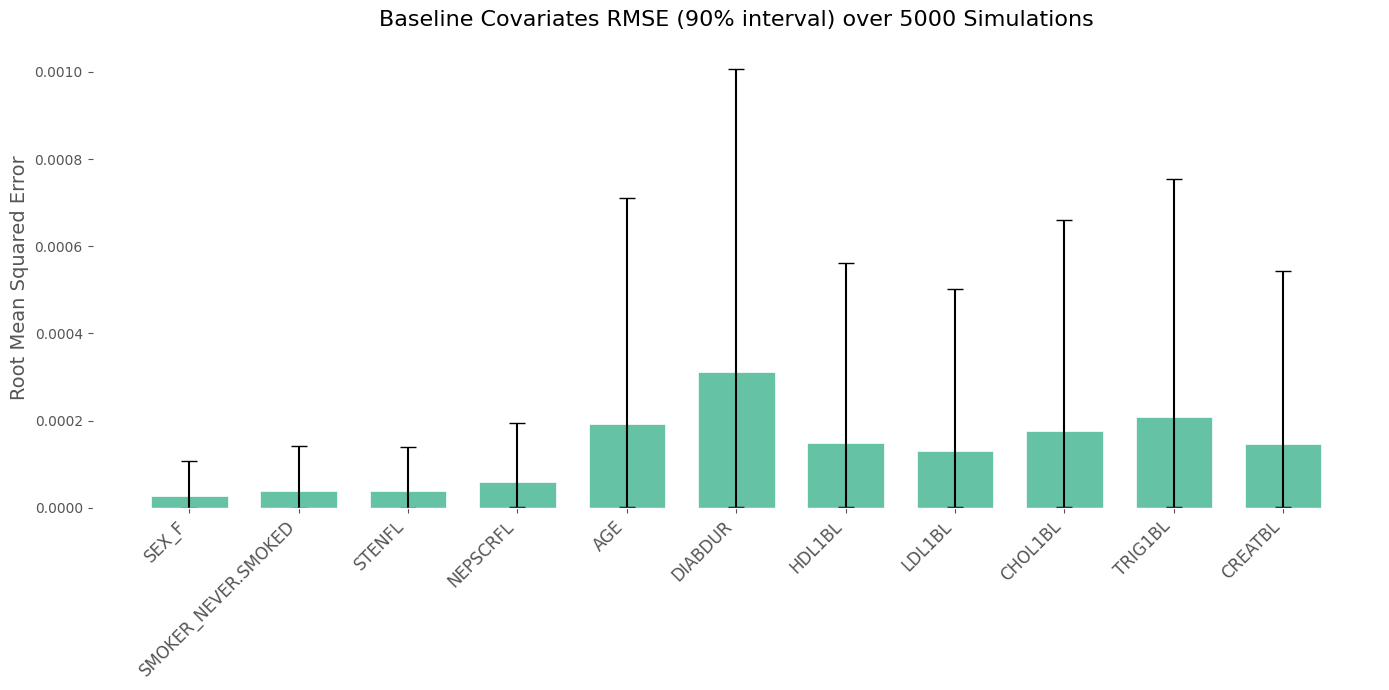

Accuracy:  μ=0.497, σ=0.007, [0.462–0.522]
AUC:       μ=0.496, σ=0.006, [0.470–0.520]


In [14]:
mse_df = pd.DataFrame(covariate_squared_errors)

# quantiles
mse_mean = mse_df.mean()
qs = mse_df.quantile([0.05, 0.95])
lower_err = mse_mean - qs.loc[0.05]
upper_err = qs.loc[0.95] - mse_mean
yerr = np.vstack([lower_err, upper_err])

# plot
cmap = plt.get_cmap('Set2')
single_color = cmap(0)   # index 2 is the 3rd color in Set2

# --- plot with that color for every bar ---
fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.bar(
    x, mse_mean,
    yerr=yerr,
    capsize=6,
    width=0.7,
    color=single_color,
    edgecolor='white'
)

ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.grid(axis='y', linestyle='--', alpha=0.6)
for spine in ['top','right','left']:
    ax.spines[spine].set_visible(False)

ax.set_xticks(x)
ax.set_xticklabels(mse_mean.index, rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=14)
ax.set_title(
    f'Baseline Covariates RMSE (90% interval) over {num_simulations} Simulations',
    fontsize=16, pad=15
)

plt.tight_layout()
plt.show()

# --- 4) Summary of classification performance -------------------------------
print(f"Accuracy:  μ={np.mean(accuracy_list):.3f}, σ={np.std(accuracy_list, ddof=1):.3f}, "
      f"[{np.min(accuracy_list):.3f}–{np.max(accuracy_list):.3f}]")
print(f"AUC:       μ={np.mean(auc_list):.3f}, σ={np.std(auc_list, ddof=1):.3f}, "
      f"[{np.min(auc_list):.3f}–{np.max(auc_list):.3f}]")

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

# ... (build combined_df with 'label' as before) ...

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Train a Random Forest classifier
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

# Predictions and probabilities
y_pred      = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
auc      = roc_auc_score(y_test, y_pred_proba)
report   = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC:  {auc:.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.94      0.69      2619
           1       0.79      0.22      0.35      2619

    accuracy                           0.58      5238
   macro avg       0.67      0.58      0.52      5238
weighted avg       0.67      0.58      0.52      5238

Accuracy: 0.58
ROC AUC:  0.69


## Train surv

In [16]:
torch.manual_seed(42)
model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=3, T=11, s_dim = s_tensor.shape[1], noise_dim=50, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
model.train_e(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=10000, lr=5e-3, print_every_iter=1000)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=10000, lr=5e-3, print_every_iter=1000,reg_lambda=1)

Epoch 1: loss 5.1451, loss1 5.3930, loss2 0.4957
Epoch 1000: loss 2.9941, loss1 5.8859, loss2 5.7836
Epoch 2000: loss 2.5035, loss1 4.9226, loss2 4.8381
Epoch 3000: loss 2.2347, loss1 4.4306, loss2 4.3918
Epoch 4000: loss 2.0799, loss1 4.1275, loss2 4.0952
Epoch 5000: loss 1.9864, loss1 3.9420, loss2 3.9112
Epoch 6000: loss 1.9254, loss1 3.8232, loss2 3.7956
Epoch 7000: loss 1.8920, loss1 3.7618, loss2 3.7396
Epoch 8000: loss 1.8635, loss1 3.6922, loss2 3.6573
Epoch 9000: loss 1.8446, loss1 3.6430, loss2 3.5969
Epoch 10000: loss 1.8099, loss1 3.5870, loss2 3.5540
Epoch 1: loss 46867886080.0000,	loss_y 1.6481, 1.6831, 0.0701,	loss_eta 3.1347, 3.2673, 0.2653, 	marginal_loss 46867886080.0000
Epoch 1: y_sample_mean 0.0129334582015872
Epoch 1: y_sample1_cat.float().mean() 0.5072685480117798
Epoch 1000: loss 4.7721,	loss_y 0.1407, 0.1822, 0.0830,	loss_eta 3.2032, 6.5079, 6.6094, 	marginal_loss 1.4283
Epoch 1000: y_sample_mean 0.01301676593720913
Epoch 1000: y_sample1_cat.float().mean() 0.005

In [17]:
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=40000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 5.4215, loss1 5.6597, loss2 0.4765
Epoch 1000: loss 1.5876, loss1 3.1826, loss2 3.1901
Epoch 2000: loss 1.5029, loss1 3.0338, loss2 3.0619
Epoch 3000: loss 1.3946, loss1 2.8171, loss2 2.8450
Epoch 4000: loss 1.2980, loss1 2.5968, loss2 2.5976
Epoch 5000: loss 1.2340, loss1 2.4710, loss2 2.4739
Epoch 6000: loss 1.1773, loss1 2.3565, loss2 2.3584
Epoch 7000: loss 1.1408, loss1 2.2614, loss2 2.2411
Epoch 8000: loss 1.1061, loss1 2.2196, loss2 2.2269
Epoch 9000: loss 1.0913, loss1 2.1641, loss2 2.1456
Epoch 10000: loss 1.0655, loss1 2.1183, loss2 2.1055
Epoch 11000: loss 1.0420, loss1 2.0745, loss2 2.0651
Epoch 12000: loss 1.0294, loss1 2.0501, loss2 2.0414
Epoch 13000: loss 1.0159, loss1 2.0240, loss2 2.0162
Epoch 14000: loss 1.0039, loss1 1.9969, loss2 1.9861
Epoch 15000: loss 0.9990, loss1 1.9858, loss2 1.9736
Epoch 16000: loss 0.9817, loss1 1.9545, loss2 1.9455
Epoch 17000: loss 0.9790, loss1 1.9346, loss2 1.9112
Epoch 18000: loss 0.9628, loss1 1.9234, loss2 1.9210
Epoch 

In [18]:
model.train_e(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=8000, lr=5e-3, print_every_iter=1000)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=8000, lr=5e-3, print_every_iter=1000,reg_lambda=1)
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=10000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 1.8106, loss1 3.5785, loss2 3.5359
Epoch 1000: loss 1.7953, loss1 3.5572, loss2 3.5238
Epoch 2000: loss 1.8082, loss1 3.5501, loss2 3.4839
Epoch 3000: loss 1.7550, loss1 3.4726, loss2 3.4352
Epoch 4000: loss 1.7604, loss1 3.4902, loss2 3.4595
Epoch 5000: loss 1.7336, loss1 3.4444, loss2 3.4217
Epoch 6000: loss 1.7371, loss1 3.4307, loss2 3.3872
Epoch 7000: loss 1.7090, loss1 3.3822, loss2 3.3464
Epoch 8000: loss 1.7097, loss1 3.3827, loss2 3.3460
Epoch 1: loss 3.4731,	loss_y 0.1322, 0.2473, 0.2302,	loss_eta 3.1547, 6.3405, 6.3717, 	marginal_loss 0.1862
Epoch 1: y_sample_mean 0.012891804799437523
Epoch 1: y_sample1_cat.float().mean() 0.013025816529989243
Epoch 1000: loss 2.6277,	loss_y 0.1289, 0.2490, 0.2401,	loss_eta 2.3007, 4.7519, 4.9023, 	marginal_loss 0.1981
Epoch 1000: y_sample_mean 0.012881391681730747
Epoch 1000: y_sample1_cat.float().mean() 0.012953139841556549
Epoch 2000: loss 2.6294,	loss_y 0.1306, 0.2495, 0.2378,	loss_eta 2.2939, 4.6904, 4.7930, 	marginal_loss 

In [ ]:
# torch.save(model,"results/model_joint_final_v2.pt")
# model_old=torch.load("results/model_joint_final.pt")
# model.model_xz = copy.deepcopy(model_old.model_xz)

In [10]:
model = torch.load("results/model_joint_final_v2.pt")

In [44]:
model.train_e(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=8000, lr=1e-3, print_every_iter=1000)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=8000, lr=5e-3, print_every_iter=1000,reg_lambda=0.5)
# model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=10000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 1.6974, loss1 3.3770, loss2 3.3593
Epoch 1000: loss 1.6194, loss1 3.1674, loss2 3.0959
Epoch 2000: loss 1.6143, loss1 3.1423, loss2 3.0560
Epoch 3000: loss 1.6128, loss1 3.1402, loss2 3.0548
Epoch 4000: loss 1.6022, loss1 3.1188, loss2 3.0331
Epoch 5000: loss 1.5972, loss1 3.1238, loss2 3.0532
Epoch 6000: loss 1.5927, loss1 3.1138, loss2 3.0420
Epoch 7000: loss 1.5872, loss1 3.0836, loss2 2.9927
Epoch 8000: loss 1.5858, loss1 3.0835, loss2 2.9953
Epoch 1: loss 2.5212,	loss_y 0.1275, 0.2521, 0.2493,	loss_eta 2.2914, 4.7307, 4.8787, 	marginal_loss 0.2048
Epoch 1: y_sample_mean 0.012870977632701397
Epoch 1: y_sample1_cat.float().mean() 0.013284756802022457
Epoch 1000: loss 2.5391,	loss_y 0.1269, 0.2455, 0.2374,	loss_eta 2.3116, 4.6819, 4.7406, 	marginal_loss 0.2012
Epoch 1000: y_sample_mean 0.013079246506094933
Epoch 1000: y_sample1_cat.float().mean() 0.012521340511739254
Epoch 2000: loss 2.5282,	loss_y 0.1290, 0.2515, 0.2451,	loss_eta 2.2990, 4.6144, 4.6308, 	marginal_loss 

In [ ]:
model.train_e(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=20000, lr=5e-3, print_every_iter=1000)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=8000, lr=5e-3, print_every_iter=1000,reg_lambda=0.2)

Epoch 1: loss 1.5886, loss1 3.0791, loss2 2.9811
Epoch 1000: loss 1.6805, loss1 3.3094, loss2 3.2578
Epoch 2000: loss 1.6874, loss1 3.3095, loss2 3.2442
Epoch 3000: loss 1.6619, loss1 3.2820, loss2 3.2402
Epoch 4000: loss 1.6517, loss1 3.2829, loss2 3.2624
Epoch 5000: loss 1.6694, loss1 3.2877, loss2 3.2367
Epoch 6000: loss 1.6610, loss1 3.2581, loss2 3.1941
Epoch 7000: loss 1.6634, loss1 3.2610, loss2 3.1952
Epoch 8000: loss 1.6413, loss1 3.2427, loss2 3.2029
Epoch 9000: loss 1.6171, loss1 3.2352, loss2 3.2362
Epoch 10000: loss 1.6471, loss1 3.2418, loss2 3.1895
Epoch 11000: loss 1.6282, loss1 3.2250, loss2 3.1937
Epoch 12000: loss 1.6362, loss1 3.2125, loss2 3.1526
Epoch 13000: loss 1.6343, loss1 3.2131, loss2 3.1576
Epoch 14000: loss 1.6525, loss1 3.2256, loss2 3.1460
Epoch 15000: loss 1.6055, loss1 3.1827, loss2 3.1543
Epoch 16000: loss 1.6341, loss1 3.2124, loss2 3.1567
Epoch 17000: loss 1.6119, loss1 3.1854, loss2 3.1471
Epoch 18000: loss 1.6056, loss1 3.1599, loss2 3.1085
Epoch 

In [152]:
model.train_e(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=5000, lr=1e-3, print_every_iter=1000)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=5000, lr=5e-3, print_every_iter=1000,reg_lambda=0.2)

Epoch 1: loss 1.5188, loss1 2.9242, loss2 2.8108
Epoch 1000: loss 1.5131, loss1 2.9275, loss2 2.8287
Epoch 2000: loss 1.5049, loss1 2.9121, loss2 2.8144
Epoch 3000: loss 1.5093, loss1 2.9184, loss2 2.8183
Epoch 4000: loss 1.5093, loss1 2.9070, loss2 2.7954
Epoch 5000: loss 1.5038, loss1 2.9021, loss2 2.7965
Epoch 1: loss 2.4516,	loss_y 0.1225, 0.2446, 0.2443,	loss_eta 2.2897, 4.6317, 4.6840, 	marginal_loss 0.1974
Epoch 1: y_sample_mean 0.01301676593720913
Epoch 1: y_sample1_cat.float().mean() 0.01273296494036913
Epoch 1000: loss 2.4649,	loss_y 0.1236, 0.2486, 0.2500,	loss_eta 2.3012, 4.6343, 4.6662, 	marginal_loss 0.2005
Epoch 1000: y_sample_mean 0.012995938770473003
Epoch 1000: y_sample1_cat.float().mean() 0.013139740563929081
Epoch 2000: loss 2.4433,	loss_y 0.1237, 0.2484, 0.2493,	loss_eta 2.2813, 4.6269, 4.6913, 	marginal_loss 0.1917
Epoch 2000: y_sample_mean 0.012870977632701397
Epoch 2000: y_sample1_cat.float().mean() 0.013214471749961376
Epoch 3000: loss 2.4680,	loss_y 0.1239, 0.

In [168]:
model.train_e(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=3000, lr=1e-3, print_every_iter=1000)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=5000, lr=5e-3, print_every_iter=1000,reg_lambda=0.2)

Epoch 1: loss 1.5097, loss1 2.9055, loss2 2.7917
Epoch 1000: loss 1.5025, loss1 2.9091, loss2 2.8134
Epoch 2000: loss 1.4992, loss1 2.8981, loss2 2.7978
Epoch 3000: loss 1.5010, loss1 2.9049, loss2 2.8079
Epoch 1: loss 2.4724,	loss_y 0.1237, 0.2483, 0.2494,	loss_eta 2.3081, 4.6746, 4.7328, 	marginal_loss 0.2030
Epoch 1: y_sample_mean 0.012912631034851074
Epoch 1: y_sample1_cat.float().mean() 0.013066336512565613
Epoch 1000: loss 2.4803,	loss_y 0.1235, 0.2490, 0.2510,	loss_eta 2.3165, 4.6065, 4.5801, 	marginal_loss 0.2014
Epoch 1000: y_sample_mean 0.013089659623801708
Epoch 1000: y_sample1_cat.float().mean() 0.01313550304621458
Epoch 2000: loss 2.4546,	loss_y 0.1227, 0.2457, 0.2460,	loss_eta 2.2915, 4.6260, 4.6691, 	marginal_loss 0.2019
Epoch 2000: y_sample_mean 0.012870977632701397
Epoch 2000: y_sample1_cat.float().mean() 0.01328519731760025
Epoch 3000: loss 2.4537,	loss_y 0.1220, 0.2464, 0.2488,	loss_eta 2.2926, 4.6508, 4.7164, 	marginal_loss 0.1958
Epoch 3000: y_sample_mean 0.0129646

In [11]:
model.train_e(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=3000, lr=1e-3, print_every_iter=1000)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=5000, lr=5e-3, print_every_iter=1000,reg_lambda=0.2)

Epoch 1: loss 1.5065, loss1 2.8996, loss2 2.7863
Epoch 1000: loss 1.4968, loss1 2.9002, loss2 2.8068
Epoch 2000: loss 1.4933, loss1 2.8929, loss2 2.7993
Epoch 3000: loss 1.4974, loss1 2.8997, loss2 2.8045
Epoch 1: loss 2.4629,	loss_y 0.1233, 0.2438, 0.2411,	loss_eta 2.2977, 4.6106, 4.6259, 	marginal_loss 0.2100
Epoch 1: y_sample_mean 0.012912631034851074
Epoch 1: y_sample1_cat.float().mean() 0.012790048494935036
Epoch 1000: loss 2.4675,	loss_y 0.1250, 0.2478, 0.2455,	loss_eta 2.3045, 4.6428, 4.6766, 	marginal_loss 0.1897
Epoch 1000: y_sample_mean 0.013089659623801708
Epoch 1000: y_sample1_cat.float().mean() 0.013114727102220058
Epoch 2000: loss 2.4561,	loss_y 0.1257, 0.2495, 0.2475,	loss_eta 2.2886, 4.5864, 4.5956, 	marginal_loss 0.2090
Epoch 2000: y_sample_mean 0.012870977632701397
Epoch 2000: y_sample1_cat.float().mean() 0.013382050208747387
Epoch 3000: loss 2.4508,	loss_y 0.1219, 0.2482, 0.2526,	loss_eta 2.2898, 4.6493, 4.7190, 	marginal_loss 0.1954
Epoch 3000: y_sample_mean 0.01296

In [25]:
model.train_e(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=4000, lr=1e-3, print_every_iter=1000)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=5000, lr=5e-3, print_every_iter=1000,reg_lambda=0.2)

Epoch 1: loss 1.5029, loss1 2.8954, loss2 2.7850
Epoch 1000: loss 1.4935, loss1 2.8940, loss2 2.8011
Epoch 2000: loss 1.4896, loss1 2.8876, loss2 2.7960
Epoch 3000: loss 1.4961, loss1 2.8942, loss2 2.7961
Epoch 4000: loss 1.4970, loss1 2.8841, loss2 2.7742
Epoch 1: loss 2.4474,	loss_y 0.1262, 0.2457, 0.2391,	loss_eta 2.2807, 4.6003, 4.6393, 	marginal_loss 0.2028
Epoch 1: y_sample_mean 0.013027179054915905
Epoch 1: y_sample1_cat.float().mean() 0.01264157798141241
Epoch 1000: loss 2.4463,	loss_y 0.1248, 0.2494, 0.2492,	loss_eta 2.2827, 4.5859, 4.6065, 	marginal_loss 0.1941
Epoch 1000: y_sample_mean 0.012881391681730747
Epoch 1000: y_sample1_cat.float().mean() 0.013083294965326786
Epoch 2000: loss 2.4623,	loss_y 0.1261, 0.2486, 0.2450,	loss_eta 2.2954, 4.7090, 4.8272, 	marginal_loss 0.2038
Epoch 2000: y_sample_mean 0.013079246506094933
Epoch 2000: y_sample1_cat.float().mean() 0.012854060158133507
Epoch 3000: loss 2.4689,	loss_y 0.1242, 0.2507, 0.2529,	loss_eta 2.3060, 4.6881, 4.7641, 	mar

In [39]:
model.train_e(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=5000, lr=1e-3, print_every_iter=1000)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=3000, lr=5e-3, print_every_iter=1000,reg_lambda=0.2)

Epoch 1: loss 1.4986, loss1 2.8805, loss2 2.7637
Epoch 1000: loss 1.4894, loss1 2.8837, loss2 2.7885
Epoch 2000: loss 1.4854, loss1 2.8792, loss2 2.7877
Epoch 3000: loss 1.4925, loss1 2.8858, loss2 2.7867
Epoch 4000: loss 1.4941, loss1 2.8785, loss2 2.7689
Epoch 5000: loss 1.4909, loss1 2.8717, loss2 2.7616
Epoch 1: loss 2.4576,	loss_y 0.1237, 0.2449, 0.2424,	loss_eta 2.2936, 4.6235, 4.6598, 	marginal_loss 0.2013
Epoch 1: y_sample_mean 0.01301676593720913
Epoch 1: y_sample1_cat.float().mean() 0.01277229841798544
Epoch 1000: loss 2.4654,	loss_y 0.1228, 0.2477, 0.2499,	loss_eta 2.3032, 4.6846, 4.7628, 	marginal_loss 0.1971
Epoch 1000: y_sample_mean 0.012995938770473003
Epoch 1000: y_sample1_cat.float().mean() 0.013589225709438324
Epoch 2000: loss 2.4563,	loss_y 0.1260, 0.2412, 0.2305,	loss_eta 2.2895, 4.6180, 4.6570, 	marginal_loss 0.2044
Epoch 2000: y_sample_mean 0.012870977632701397
Epoch 2000: y_sample1_cat.float().mean() 0.012028168886899948
Epoch 3000: loss 2.4797,	loss_y 0.1224, 0.

In [96]:
model.train_e(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=5000, lr=1e-3, print_every_iter=1000)
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=5000, lr=5e-3, print_every_iter=1000,reg_lambda=0.2)

Epoch 1: loss 1.4913, loss1 2.8762, loss2 2.7698
Epoch 1000: loss 1.4841, loss1 2.8750, loss2 2.7817
Epoch 2000: loss 1.4833, loss1 2.8692, loss2 2.7718
Epoch 3000: loss 1.4877, loss1 2.8775, loss2 2.7797
Epoch 4000: loss 1.4899, loss1 2.8691, loss2 2.7584
Epoch 5000: loss 1.4878, loss1 2.8654, loss2 2.7553
Epoch 1: loss 2.4481,	loss_y 0.1236, 0.2512, 0.2551,	loss_eta 2.2857, 4.6553, 4.7392, 	marginal_loss 0.1942
Epoch 1: y_sample_mean 0.01301676593720913
Epoch 1: y_sample1_cat.float().mean() 0.013509164564311504
Epoch 1000: loss 2.4659,	loss_y 0.1249, 0.2509, 0.2520,	loss_eta 2.3012, 4.6977, 4.7929, 	marginal_loss 0.1987
Epoch 1000: y_sample_mean 0.012995938770473003
Epoch 1000: y_sample1_cat.float().mean() 0.013170944526791573
Epoch 2000: loss 2.4544,	loss_y 0.1257, 0.2468, 0.2423,	loss_eta 2.2892, 4.6474, 4.7164, 	marginal_loss 0.1974
Epoch 2000: y_sample_mean 0.012870977632701397
Epoch 2000: y_sample1_cat.float().mean() 0.012394209392368793
Epoch 3000: loss 2.4725,	loss_y 0.1226, 0

### previous log

In [ ]:
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=500, lr=5e-3, print_every_iter=100,reg_lambda=0.2)
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=2000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 2.4922,	loss_y 0.1305, 0.2468, 0.2325,	loss_eta 2.2871, 4.8610, 5.1479, 	marginal_loss 0.3729
Epoch 1: y_sample_mean 0.012798083946108818
Epoch 1: y_sample1_cat.float().mean() 0.012114065699279308
Epoch 100: loss 2.5011,	loss_y 0.1306, 0.2522, 0.2432,	loss_eta 2.2948, 4.8604, 5.1312, 	marginal_loss 0.3786
Epoch 100: y_sample_mean 0.012964698486030102
Epoch 100: y_sample1_cat.float().mean() 0.012698168866336346
Epoch 200: loss 2.4953,	loss_y 0.1316, 0.2548, 0.2463,	loss_eta 2.2886, 4.9032, 5.2292, 	marginal_loss 0.3753
Epoch 200: y_sample_mean 0.013100072741508484
Epoch 200: y_sample1_cat.float().mean() 0.012728837318718433
Epoch 300: loss 2.5173,	loss_y 0.1310, 0.2548, 0.2476,	loss_eta 2.3121, 4.9308, 5.2374, 	marginal_loss 0.3707
Epoch 300: y_sample_mean 0.012860564514994621
Epoch 300: y_sample1_cat.float().mean() 0.012761722318828106
Epoch 400: loss 2.4911,	loss_y 0.1285, 0.2519, 0.2468,	loss_eta 2.2876, 4.9678, 5.3603, 	marginal_loss 0.3748
Epoch 400: y_sample_mean 0.0

In [107]:
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=500, lr=5e-3, print_every_iter=100,reg_lambda=0.5)
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=5000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 2.6230,	loss_y 0.1282, 0.2560, 0.2556,	loss_eta 2.3095, 4.9279, 5.2370, 	marginal_loss 0.3705
Epoch 1: y_sample_mean 0.012912631034851074
Epoch 1: y_sample1_cat.float().mean() 0.012938199564814568
Epoch 100: loss 2.6002,	loss_y 0.1286, 0.2508, 0.2443,	loss_eta 2.2846, 4.9418, 5.3146, 	marginal_loss 0.3740
Epoch 100: y_sample_mean 0.01272519025951624
Epoch 100: y_sample1_cat.float().mean() 0.012187826447188854
Epoch 200: loss 2.5907,	loss_y 0.1299, 0.2519, 0.2441,	loss_eta 2.2719, 4.9555, 5.3672, 	marginal_loss 0.3778
Epoch 200: y_sample_mean 0.0129334582015872
Epoch 200: y_sample1_cat.float().mean() 0.012291454710066319
Epoch 300: loss 2.6202,	loss_y 0.1293, 0.2529, 0.2472,	loss_eta 2.3002, 4.9866, 5.3727, 	marginal_loss 0.3814
Epoch 300: y_sample_mean 0.012943871319293976
Epoch 300: y_sample1_cat.float().mean() 0.012962336651980877
Epoch 400: loss 2.6115,	loss_y 0.1296, 0.2530, 0.2469,	loss_eta 2.2948, 4.9741, 5.3587, 	marginal_loss 0.3743
Epoch 400: y_sample_mean 0.0128

In [123]:
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=500, lr=5e-3, print_every_iter=100,reg_lambda=1)
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=20000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 2.7847,	loss_y 0.1298, 0.2550, 0.2504,	loss_eta 2.2769, 4.9791, 5.4044, 	marginal_loss 0.3780
Epoch 1: y_sample_mean 0.012985525652766228
Epoch 1: y_sample1_cat.float().mean() 0.013613850809633732
Epoch 100: loss 2.8043,	loss_y 0.1316, 0.2574, 0.2516,	loss_eta 2.2936, 4.9756, 5.3641, 	marginal_loss 0.3790
Epoch 100: y_sample_mean 0.012964698486030102
Epoch 100: y_sample1_cat.float().mean() 0.013186726719141006
Epoch 200: loss 2.7877,	loss_y 0.1298, 0.2543, 0.2490,	loss_eta 2.2823, 4.9578, 5.3510, 	marginal_loss 0.3757
Epoch 200: y_sample_mean 0.012943871319293976
Epoch 200: y_sample1_cat.float().mean() 0.013115339912474155
Epoch 300: loss 2.7915,	loss_y 0.1305, 0.2559, 0.2508,	loss_eta 2.2883, 4.9833, 5.3900, 	marginal_loss 0.3726
Epoch 300: y_sample_mean 0.012860564514994621
Epoch 300: y_sample1_cat.float().mean() 0.013261179439723492
Epoch 400: loss 2.7944,	loss_y 0.1294, 0.2525, 0.2462,	loss_eta 2.2907, 4.9763, 5.3712, 	marginal_loss 0.3743
Epoch 400: y_sample_mean 0.0

## Evaluation

In [97]:
def missing_impute(y, x=None, z=None, x_dim=1, z_dim=1, missing_to_num=-1):
    y_out = y.clone() 
    event_indicator = (y_out > 0).float()
    c = torch.cumsum(event_indicator, dim=1)
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    mask = (c_shifted > 0)
    y_out[mask] = missing_to_num

    if x is None and z is None:
        return y_out

    n_obs, timesteps = y.shape  
    x_out = None
    if x is not None:
        x_out = x.clone().view(n_obs, timesteps, x_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, x_dim)
        x_out[mask_expanded] = missing_to_num
        x_out = x_out.view(n_obs, timesteps * x_dim)

    z_out = None
    if z is not None:
        z_out = z.clone().view(n_obs, timesteps, z_dim)
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, z_dim)
        z_out[mask_expanded] = missing_to_num
        z_out = z_out.view(n_obs, timesteps * z_dim)

    return x_out, z_out, y_out


# Define overall time grid (11 time points) and the observed indices for z2 and z3.
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]  # indices 0,...,10
# Given original measurement times for z2 and z3: 0, 12, 24, 36, 48, 6, 60,
# sort them into increasing order: 0, 6, 12, 24, 36, 48, 60.
# The corresponding indices in the overall time grid are:
observed_idx = [0, 1, 2, 4, 6, 8, 10]

In [98]:
import torch
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split



x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)


s_true_np = s_tensor.detach().cpu().numpy()   # shape: (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # shape: (n_obs, 11)

# Reshape z_tensor to (n_obs, 11, 3)
n_obs = z_tensor.shape[0]
z_true_reshaped = z_tensor.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
# Extract z1: use all 11 time points
z1_true = z_true_reshaped[:, :, 0]              # shape: (n_obs, 11)
# For z2 and z3: extract only the observed indices
z2_true = z_true_reshaped[:, observed_idx, 1]     # shape: (n_obs, len(observed_idx))
z3_true = z_true_reshaped[:, observed_idx, 2]     # shape: (n_obs, len(observed_idx))

# Create column names for each block of features.
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_{t}' for t in time_points]  # all time points for z1
y_cols  = [f'y_{t}' for t in time_points]
z2_cols = [f'z2_{time_points[i]}' for i in observed_idx]
z3_cols = [f'z3_{time_points[i]}' for i in observed_idx]

# Build the original (true) joint DataFrame by concatenating the features along the columns.
original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true,y_true_np], axis=1),
    columns =  s_cols+ z1_cols+ y_cols
)
original_joint_df['source'] = 'Original'

# --------------------------------------------------------------------
# --- Simulation Loop ---
num_simulations = 500  
accuracy_list = []
auc_list = []


for i in range(num_simulations):
    # (1) simulate baseline & joint as before
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)

    # (2) missing‐impute
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)

    # (3) build simulated_joint_df exactly as you did
    s_pred_np = s_pred.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    z_pred_reshaped = z_pred.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
    z1_pred = z_pred_reshaped[:, :, 0]
    z2_pred = z_pred_reshaped[:, observed_idx, 1]
    z3_pred = z_pred_reshaped[:, observed_idx, 2]

    simulated_joint_df = pd.DataFrame(
        np.concatenate([ s_pred, z1_pred, y_pred], axis=1),
        columns = s_cols+ z1_cols + y_cols 
    )
    simulated_joint_df['source'] = 'Simulated'

    # (4) combine original & simulated
    combined = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True).round(1)
    X = combined.drop(columns='source')
    y = combined['source'].map({'Original': 0, 'Simulated': 1})

    # (5) train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=2025, stratify=y
    )

    # ===== HERE: Random Forest instead of Logistic Regression =====
    clf_joint = RandomForestClassifier(
        n_estimators=100,
        max_depth=4,
        random_state=2025,
        n_jobs=-1
    )
    clf_joint.fit(X_train, y_train)

    y_pred_lbl   = clf_joint.predict(X_test)
    y_pred_proba = clf_joint.predict_proba(X_test)[:, 1]

    accuracy_list.append(accuracy_score(y_test, y_pred_lbl))
    auc_list     .append(roc_auc_score(y_test, y_pred_proba))

# --- Print Summary Statistics ---
print(f"Joint Data Classification Results over {num_simulations} sims:")
print(f"Accuracy: Mean={np.mean(accuracy_list):.3f}, Std={np.std(accuracy_list,ddof=1):.3f}, "
      f"Min={np.min(accuracy_list):.3f}, Max={np.max(accuracy_list):.3f}")
print(f"AUC:      Mean={np.mean(auc_list):.3f}, Std={np.std(auc_list,ddof=1):.3f}, "
      f"Min={np.min(auc_list):.3f}, Max={np.max(auc_list):.3f}")


Joint Data Classification Results over 500 sims:
Accuracy: Mean=0.686, Std=0.006, Min=0.670, Max=0.702
AUC:      Mean=0.773, Std=0.006, Min=0.754, Max=0.789


In [99]:
clf_joint.feature_importances_

array([1.42577632e-04, 2.04495686e-04, 1.11374823e-04, 2.04939652e-04,
       1.12683031e-02, 6.53187773e-03, 1.17520448e-03, 1.55693577e-03,
       1.37438570e-03, 5.52140881e-03, 2.33916175e-03, 1.57726441e-01,
       4.63482886e-02, 9.13395390e-02, 1.04915798e-01, 5.90297859e-02,
       4.55033725e-02, 1.01153848e-01, 7.67783110e-02, 8.38510651e-02,
       7.83700167e-02, 1.23108258e-01, 0.00000000e+00, 0.00000000e+00,
       8.09851663e-05, 3.60049308e-04, 2.66839386e-05, 2.38622360e-04,
       1.36461059e-04, 2.55201584e-04, 7.47836583e-05, 1.26227706e-04,
       1.45595965e-04])

In [100]:
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)


s_true_np = s_tensor.detach().cpu().numpy()   # shape: (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # shape: (n_obs, 11)

# Reshape z_tensor to (n_obs, 11, 3)
n_obs = z_tensor.shape[0]
z_true_reshaped = z_tensor.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
# Extract z1: use all 11 time points
z1_true = z_true_reshaped[:, :, 0]              # shape: (n_obs, 11)
# For z2 and z3: extract only the observed indices
z2_true = z_true_reshaped[:, observed_idx, 1]     # shape: (n_obs, len(observed_idx))
z3_true = z_true_reshaped[:, observed_idx, 2]     # shape: (n_obs, len(observed_idx))

# Create column names for each block of features.
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_{t}' for t in time_points]  # all time points for z1
y_cols  = [f'y_{t}' for t in time_points]
z2_cols = [f'z2_{time_points[i]}' for i in observed_idx]
z3_cols = [f'z3_{time_points[i]}' for i in observed_idx]

# Build the original (true) joint DataFrame by concatenating the features along the columns.
original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true,y_true_np], axis=1),
    columns =  s_cols+ z1_cols+ y_cols
)
original_joint_df['source'] = 'Original'

# --------------------------------------------------------------------
# --- Simulation Loop ---
num_simulations = 500
accuracy_list = []
auc_list = []


for i in range(num_simulations):
    # (1) simulate baseline & joint as before
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)

    # (2) missing‐impute
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)

    # (3) build simulated_joint_df exactly as you did
    s_pred_np = s_pred.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    z_pred_reshaped = z_pred.reshape(n_obs, len(time_points), 3).detach().cpu().numpy()
    z1_pred = z_pred_reshaped[:, :, 0]
    z2_pred = z_pred_reshaped[:, observed_idx, 1]
    z3_pred = z_pred_reshaped[:, observed_idx, 2]

    simulated_joint_df = pd.DataFrame(
        np.concatenate([ s_pred, z1_pred, y_pred], axis=1),
        columns = s_cols+ z1_cols + y_cols 
    )
    simulated_joint_df['source'] = 'Simulated'

    # (4) combine original & simulated
    combined = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True).round(1)
    X = combined.drop(columns='source')
    y = combined['source'].map({'Original': 0, 'Simulated': 1})

    # (5) train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=2025, stratify=y
    )

    
    # Train the logistic regression classifier.
    clf_joint = LogisticRegression(max_iter=1000)
    clf_joint.fit(X_train, y_train)
    

    y_joint_pred = clf_joint.predict(X_test)
    y_joint_pred_proba = clf_joint.predict_proba(X_test)[:, 1]
    

    accuracy_joint = accuracy_score(y_test, y_joint_pred)
    auc_joint = roc_auc_score(y_test, y_joint_pred_proba)
    

    accuracy_list.append(accuracy_joint)
    auc_list.append(auc_joint)

# --- Print Summary Statistics ---
print("Joint Data Classification Results (over {} simulations):".format(num_simulations))
print("Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))

Joint Data Classification Results (over 500 simulations):
Accuracy: Mean=0.531, Std=0.007, Min=0.509, Max=0.552
AUC: Mean=0.542, Std=0.008, Min=0.517, Max=0.569


In [101]:
clf_joint.coef_

array([[-7.34641373e-04, -2.20160666e-02, -5.73528227e-02,
        -1.06289404e-01,  3.34346536e-03,  3.14920202e-02,
        -2.30492042e-03,  5.93033739e-02, -6.32524724e-02,
         1.67462137e-02,  1.63063015e-02, -6.53971074e-02,
         1.47116579e-01, -5.01298959e-02, -8.21211209e-02,
        -7.75839922e-02,  1.36350503e-01, -4.76004710e-02,
        -1.22731373e-01,  2.03221953e-01,  3.11633270e-02,
        -1.04120825e-01,  0.00000000e+00, -6.53222842e-02,
         3.25248543e-02,  1.61754679e-01,  8.92174747e-02,
        -4.07469083e-02, -9.12745599e-02,  1.21720358e-01,
         1.24684938e-01, -1.18323866e+00,  1.00058971e+00]])

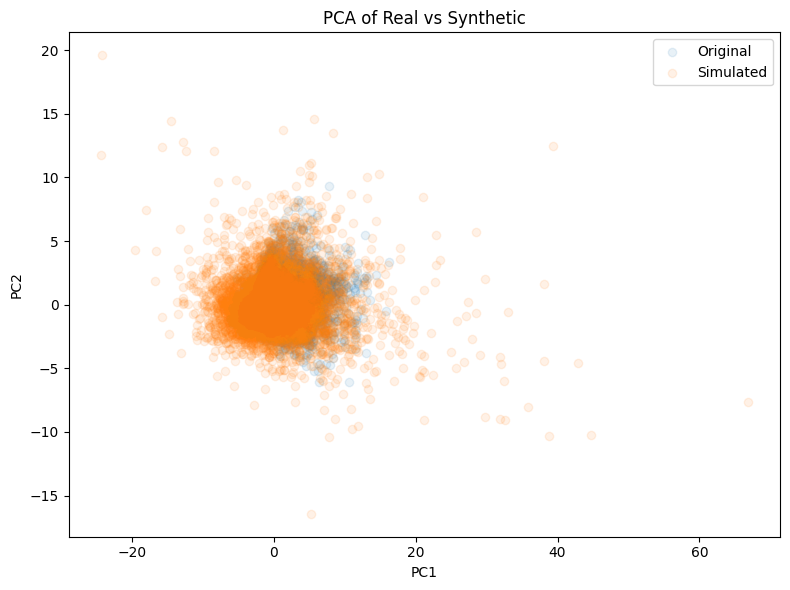

In [102]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 1) Combine your real & one simulated dataset
combined = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
X = combined.drop(columns='source').values
y = combined['source'].values  # array of 'Original' / 'Simulated'

# 2) PCA → 2D
pca = PCA(n_components=2, random_state=2025)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
for label in ['Original', 'Simulated']:
    idx = (y == label)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=label, alpha=0.1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Real vs Synthetic')
plt.legend()
plt.tight_layout()
plt.show()



In [103]:
# import numpy as np
# import matplotlib.pyplot as plt

# # --- your data as before ---
# # x = np.arange(len(mse_mean))
# # mse_mean, yerr, num_simulations defined above

# # --- pick one Set2 color ---
# cmap = plt.get_cmap('Set2')
# single_color = cmap(0)   # index 2 is the 3rd color in Set2

# # --- plot with that color for every bar ---
# fig, ax = plt.subplots(figsize=(14, 7))
# bars = ax.bar(
#     x, mse_mean,
#     yerr=yerr,
#     capsize=6,
#     width=0.7,
#     color=single_color,
#     edgecolor='white'
# )

# ax.set_facecolor('white')
# fig.patch.set_facecolor('white')
# ax.grid(axis='y', linestyle='--', alpha=0.6)
# for spine in ['top','right','left']:
#     ax.spines[spine].set_visible(False)

# ax.set_xticks(x)
# ax.set_xticklabels(mse_mean.index, rotation=45, ha='right', fontsize=12)
# ax.set_ylabel('Root Mean Squared Error', fontsize=14)
# ax.set_title(
#     f'Baseline Covariates RMSE (90% interval) over {num_simulations} Simulations',
#     fontsize=16, pad=15
# )

# plt.tight_layout()
# plt.show()


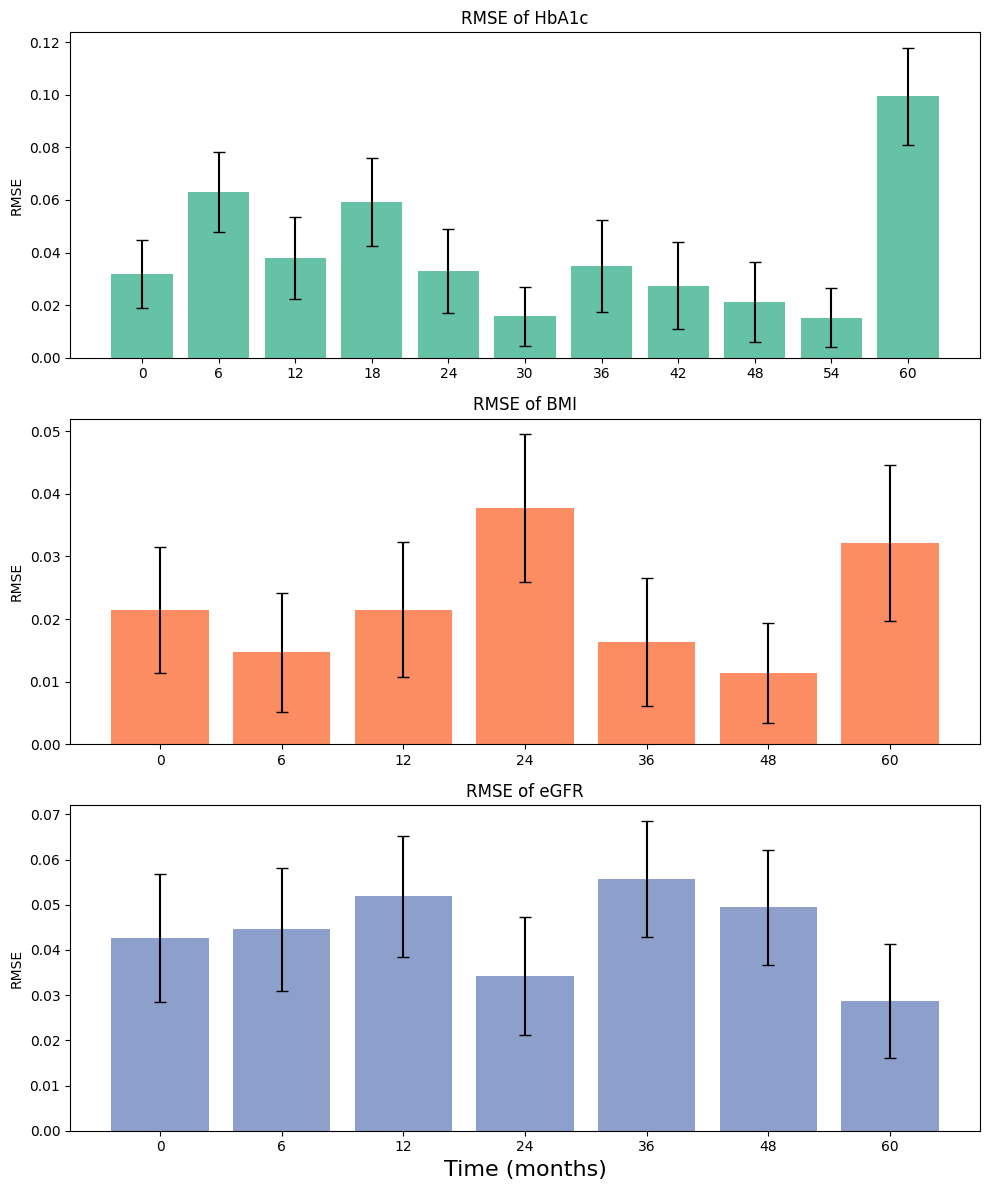

In [104]:
from matplotlib.ticker import FormatStrFormatter
num_samples   = 500                     # MC draws of the joint model
timepoints    = 11
obs_idx       = observed_idx            # [0,1,2,4,6,8,10]
n_obs, z_dim  = z_tensor.shape[0], 3

z1_samples, z2_samples, z3_samples = [], [], []

for _ in range(num_samples):
    # fresh posterior / model draw
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)

    # (2) missing‐impute
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)


    z_pred_np  = z_pred.reshape(n_obs, timepoints, z_dim).detach().cpu().numpy()

    z1_samples.append(z_pred_np[:, :, 0])        # (n_obs, 11)
    z2_samples.append(z_pred_np[:, obs_idx, 1])  # (n_obs, 7)
    z3_samples.append(z_pred_np[:, obs_idx, 2])  # (n_obs, 7)

z1_samples = np.stack(z1_samples, axis=0)
z2_samples = np.stack(z2_samples, axis=0)
z3_samples = np.stack(z3_samples, axis=0)

z_true_np     = z_tensor.reshape(n_obs, timepoints, z_dim).detach().cpu().numpy()
z1_obs_mean   = z_true_np[:, :, 0].mean(axis=0)         # (11,)
z2_obs_mean   = z_true_np[:, obs_idx, 1].mean(axis=0)   # (7,)
z3_obs_mean   = z_true_np[:, obs_idx, 2].mean(axis=0)   # (7,)


def rmse_per_sample(z_samples, z_mean_obs):
    """Return array (num_samples, T) with RMSE for each MC draw."""
    # squared error of the biomarker *mean* trajectory
    sq_err = (z_samples.mean(axis=1) - z_mean_obs[np.newaxis, :]) ** 2
    return np.sqrt(sq_err)

rmse_z1 = rmse_per_sample(z1_samples, z1_obs_mean)  # (num_samples, 11)
rmse_z2 = rmse_per_sample(z2_samples, z2_obs_mean)  # (num_samples, 7)
rmse_z3 = rmse_per_sample(z3_samples, z3_obs_mean)  # (num_samples, 7)


rmse_stats = {
    'z1': {'mean': rmse_z1.mean(axis=0), 'std': rmse_z1.std(axis=0, ddof=1)},
    'z2': {'mean': rmse_z2.mean(axis=0), 'std': rmse_z2.std(axis=0, ddof=1)},
    'z3': {'mean': rmse_z3.mean(axis=0), 'std': rmse_z3.std(axis=0, ddof=1)},
}


# PLOT 
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette("Set2")

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=False)
fig.patch.set_facecolor('white')
for ax in axes:
    ax.set_facecolor('white')
# --- z1 (11 visits) ---
time_z1 = np.arange(timepoints)
axes[0].bar(time_z1,
            rmse_stats['z1']['mean'],
            yerr=rmse_stats['z1']['std'],
            capsize=4, color=palette[0])
axes[0].set_ylabel("RMSE")
axes[0].set_title("RMSE of HbA1c")
axes[0].set_xticks(time_z1, [f"{t}" for t in time_points])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# --- z2 (observed visits) ---
time_z2 = np.arange(len(obs_idx))
axes[1].bar(time_z2,
            rmse_stats['z2']['mean'],
            yerr=rmse_stats['z2']['std'],
            capsize=4, color=palette[1])
axes[1].set_ylabel("RMSE")
axes[1].set_title("RMSE of BMI")
axes[1].set_xticks(time_z2, [f"{time_points[i]}" for i in obs_idx])

# --- z3 (observed visits) ---
time_z3 = np.arange(len(obs_idx))
axes[2].bar(time_z3,
            rmse_stats['z3']['mean'],
            yerr=rmse_stats['z3']['std'],
            capsize=4, color=palette[2])
axes[2].set_ylabel("RMSE")
axes[2].set_title("RMSE of eGFR")
axes[2].set_xticks(time_z3, [f"{time_points[i]}" for i in obs_idx])
axes[2].set_xlabel("Time (months)", fontsize=16)    

plt.tight_layout()
plt.show()


In [105]:
import torch
import numpy as np

# --- SETTINGS --------------------------------------------------------------
num_sims = 500
# s_tensor: your N×latent input for units
# x_tensor: original N×T treatment‐history (we'll just use its shape)
N0, T = s_tensor[(x_tensor[:,0]==0),:].shape
N1, T = s_tensor[(x_tensor[:,0]==1),:].shape
# Prepare “pure” control/treatment arms
x_control = torch.zeros((N0, T), dtype=torch.int32)
x_treat   = torch.ones((N1, T), dtype=torch.int32)

control_event_rates = []
treat_event_rates   = []

for _ in range(num_sims):
    # simulate y under control
    y_ctrl = model.sample_causal_margin(
        s=s_tensor[(x_tensor[:,0]==0),:],
        x=x_control,
        sample_size=1
    )
    # simulate y under treatment
    y_trt  = model.sample_causal_margin(
        s=s_tensor[(x_tensor[:,0]==1),:],
        x=x_treat,
        sample_size=1
    )

    # y_ctrl, y_trt assumed shape [N, T] of 0/1’s
    # compute per‐unit “ever an event” indicator
    ever_ctrl = (y_ctrl.sum(dim=1) > 0).float()
    ever_trt  = (y_trt.sum(dim=1) > 0).float()

    # fraction of units with ≥1 event
    control_event_rates.append(ever_ctrl.mean().item())
    treat_event_rates.append( ever_trt.mean().item())



In [106]:
# now summarize
ctrl_min, ctrl_max = np.quantile(control_event_rates, 0.05), np.quantile(control_event_rates,0.95)
trt_min,  trt_max  = np.quantile(treat_event_rates,0.05),   np.quantile(treat_event_rates, 0.95)
ctrl_mean = np.mean(control_event_rates)
trt_mean = np.mean(treat_event_rates)

print(f"Control arm event‐rate over {num_sims} sims: {ctrl_min:.3f}–{ctrl_max:.3f}")
print(f" Treatment arm event‐rate over {num_sims} sims: {trt_min:.3f}–{trt_max:.3f}")
print(ctrl_mean)
print(trt_mean)

Control arm event‐rate over 500 sims: 0.129–0.145
 Treatment arm event‐rate over 500 sims: 0.115–0.131
0.13692110063135624
0.12313043518364429


In [107]:
import torch
import numpy as np

# --- SETTINGS --------------------------------------------------------------
num_sims = 500
# s_tensor: your N×latent input for units
# x_tensor: original N×T treatment‐history (we'll just use its shape)


control_event_rates = []
treat_event_rates   = []

for _ in range(num_sims):
    x,s_pred=model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    N0, T = s_pred[(x[:,0]==0),:].shape
    N1, T = s_pred[(x[:,0]==1),:].shape
    # Prepare “pure” control/treatment arms
    x_control = torch.zeros((N0, T), dtype=torch.int32)
    x_treat   = torch.ones((N1, T), dtype=torch.int32)
    # simulate y under control
    y_ctrl = model.sample_causal_margin(
        s=s_pred[(x[:,0]==0),:],
        x=x_control,
        sample_size=1
    )
    # simulate y under treatment
    y_trt  = model.sample_causal_margin(
        s=s_pred[(x[:,0]==1),:],
        x=x_treat,
        sample_size=1
    )

    # y_ctrl, y_trt assumed shape [N, T] of 0/1’s
    # compute per‐unit “ever an event” indicator
    ever_ctrl = (y_ctrl.sum(dim=1) > 0).float()
    ever_trt  = (y_trt.sum(dim=1) > 0).float()

    # fraction of units with ≥1 event
    control_event_rates.append(ever_ctrl.mean().item())
    treat_event_rates.append( ever_trt.mean().item())



In [108]:
# now summarize
ctrl_min, ctrl_max = np.quantile(control_event_rates, 0.05), np.quantile(control_event_rates,0.95)
trt_min,  trt_max  = np.quantile(treat_event_rates,0.05),   np.quantile(treat_event_rates, 0.95)
ctrl_mean = np.mean(control_event_rates)
trt_mean = np.mean(treat_event_rates)

print(f"Control arm event‐rate over {num_sims} sims: {ctrl_min:.3f}–{ctrl_max:.3f}")
print(f" Treatment arm event‐rate over {num_sims} sims: {trt_min:.3f}–{trt_max:.3f}")
print(ctrl_mean)
print(trt_mean)

Control arm event‐rate over 500 sims: 0.130–0.147
 Treatment arm event‐rate over 500 sims: 0.116–0.132
0.1382755036354065
0.12406476528942585


In [92]:
y_ctrl_true = y_tensor[(x_tensor[:,0]==0),:]
y_trt_true = y_tensor[(x_tensor[:,1]==0),:]

ever_ctrl_true = (y_ctrl_true.sum(dim=1) > 0).float()

In [33]:
mask = (arm_values == 1)
y_tr = y_tensor[mask,:]
y_cr = y_tensor[~mask,:]
sum(y_tr==1).sum()/y_tr.shape[0]

tensor(0.1263)

In [34]:
sum(y_cr==1).sum()/y_cr.shape[0]

tensor(0.1413)

In [109]:
torch.save(model,"results/model_joint_final_v2.pt")
# model=torch.load("results/model_joint_final.pt")

In [93]:
model = torch.load("results/model_joint_final_v2.pt")

# Cox model

In [151]:
import torch
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter

def compute_5yr_risk(y_tensor: torch.Tensor,
                     x_tensor: torch.Tensor,
                     interval_months: int = 6,
                     horizon_months: int = 60):
    """
    y_tensor: shape (N, T=11) with entries {0,1,-1}
              indexed as [0mo, 6mo, 12mo, …, 60mo]
    x_tensor: shape (N,1) treatment {0,1}
    """

    # 1. to numpy
    y = y_tensor.detach().cpu().numpy().astype(int)
    x = x_tensor.detach().cpu().numpy().reshape(-1)
    N, T = y.shape

    # 2. build (duration,event) with correct indexing & censoring
    durations = np.zeros(N, dtype=float)
    events    = np.zeros(N, dtype=int)
    for i in range(N):
        # find first event‐marker
        hits = np.where(y[i] == 1)[0]
        if hits.size > 0:
            # map index k → k*interval_months
            t_event = hits[0] * interval_months
            # if that exceeds 60, treat as censored at 60
            if t_event > horizon_months:
                durations[i] = horizon_months
                events[i]    = 0
            else:
                durations[i] = t_event
                events[i]    = 1
        else:
            # no events → censored at 60
            durations[i] = horizon_months
            events[i]    = 0

    # 3. fit Cox(treatment)
    df = pd.DataFrame({
        "time":      durations,
        "event":     events,
        "treatment": x
    })
    cph = CoxPHFitter()
    cph.fit(df, duration_col="time", event_col="event", formula="treatment")

    # 4. survival@60 → absolute risk
    sf0 = cph.predict_survival_function(
            pd.DataFrame({"treatment": [0]}),
            times=[horizon_months]
         ).iloc[0,0]
    sf1 = cph.predict_survival_function(
            pd.DataFrame({"treatment": [1]}),
            times=[horizon_months]
         ).iloc[0,0]
    risk0 = 1 - sf0
    risk1 = 1 - sf1

    return {
        "cph_summary":   cph.summary,
        "hazard_ratio":  np.exp(cph.params_["treatment"]),
        "risk_control":  risk0,
        "risk_treatment":risk1
    }

# --- USAGE on your real data ---

# make sure x_tensor is (N,1), not (N,)
x = x_tensor[:,0].reshape(-1,1)
res_real = compute_5yr_risk(y_tensor, x)

print("=== Real data Cox(treatment) ===")
print(res_real["cph_summary"])
print(f"HR(treat vs ctrl)   = {res_real['hazard_ratio']:.3f}")
print(f"5-yr risk (control) = {res_real['risk_control']:.1%}")
print(f"5-yr risk (treatment)= {res_real['risk_treatment']:.1%}")


=== Real data Cox(treatment) ===
               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
treatment -0.121454   0.885632  0.058609       -0.236325       -0.006582   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
treatment             0.789524             0.993439     0.0 -2.072275   

                 p  -log2(p)  
covariate                     
treatment  0.03824  4.708783  
HR(treat vs ctrl)   = 0.886
5-yr risk (control) = 14.0%
5-yr risk (treatment)= 12.5%


In [152]:
import torch
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter

def compute_5yr_stats_iter(y_tensor: torch.Tensor,
                      x_tensor: torch.Tensor,
                      interval_months: int = 6,
                      horizon_months: int = 60):
    # (1) to numpy
    y = y_tensor.detach().cpu().numpy().astype(int)
    x = x_tensor.detach().cpu().numpy().reshape(-1)
    N, T = y.shape

    # (2) build (duration,event)
    durations = np.zeros(N, dtype=float)
    events    = np.zeros(N, dtype=int)
    for i in range(N):
        hits = np.where(y[i] == 1)[0]
        if hits.size:
            durations[i] = (hits[0] + 1) * interval_months
            events[i]    = 1
        else:
            durations[i] = horizon_months
            events[i]    = 0

    # (3) fit Cox
    df = pd.DataFrame({
        "time":      durations,
        "event":     events,
        "treatment": x
    })
    cph = CoxPHFitter()
    cph.fit(df, duration_col="time", event_col="event", formula="treatment")

    # (4) 5-yr survival → absolute risk
    sf0 = cph.predict_survival_function(
            pd.DataFrame({"treatment":[0]}),
            times=[horizon_months]
          ).iloc[0,0]
    sf1 = cph.predict_survival_function(
            pd.DataFrame({"treatment":[1]}),
            times=[horizon_months]
          ).iloc[0,0]
    risk0 = 1 - sf0
    risk1 = 1 - sf1

    # (5) extract log-HR and its 95% CI from summary
    summ     = cph.summary.loc["treatment"]
    coef     = summ["coef"]
    ci_lower = summ["coef lower 95%"]
    ci_upper = summ["coef upper 95%"]
    p = summ['p']

    return risk0, risk1, coef, ci_lower, ci_upper,p

# ------------------------------------------------------------------------
# now run your 5,000 sims, collect everything
num_sims = 5000

risk_ctrl_sims = []
risk_trt_sims  = []
coef_sims      = []
ci_lower_sims  = []
ci_upper_sims  = []
p_sims=[]

for _ in range(num_sims):
    # draw latent & x-histories
    x_hist, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])

    # split for ctrl vs treatment
    mask0 = (x_hist[:,0] == 0)
    mask1 = (x_hist[:,0] == 1)
    N0 = mask0.sum().item()
    N1 = mask1.sum().item()
    T  = y_tensor.shape[1]

    # pure-arm x histories (we only need first column for covariate)
    x0 = torch.zeros((N0, T), dtype=torch.int32)
    x1 = torch.ones ((N1, T), dtype=torch.int32)

    # simulate y under each arm
    y0 = model.sample_causal_margin(s=s_pred[mask0], x=x0, sample_size=1)
    y1 = model.sample_causal_margin(s=s_pred[mask1], x=x1, sample_size=1)

    # stack into one big dataset
    y_sim = torch.cat([y0, y1], dim=0)                  # shape (N0+N1, T)
    x_sim = torch.cat([x0, x1], dim=0)[:, :1].float()    # shape (N0+N1, 1)

    # compute and collect
    r0, r1, coef, lo, hi,p = compute_5yr_stats_iter(y_sim, x_sim)
    risk_ctrl_sims.append(r0)
    risk_trt_sims.append(r1)
    coef_sims.append(coef)
    ci_lower_sims.append(lo)
    ci_upper_sims.append(hi)
    p_sims.append(p)



In [153]:
# ------------------------------------------------------------------------
# convert to arrays and summarize
risk_ctrl_sims = np.array(risk_ctrl_sims)
risk_trt_sims  = np.array(risk_trt_sims)
coef_sims      = np.array(coef_sims)
ci_lower_sims  = np.array(ci_lower_sims)
ci_upper_sims  = np.array(ci_upper_sims)
p_sims = np.array(p_sims)
print("=== 5-year absolute risks over sims ===")
print(f"Control : mean={risk_ctrl_sims.mean():.3%}, sd={risk_ctrl_sims.std(ddof=1):.3%}")
print(f"Treatment: mean={risk_trt_sims.mean():.3%}, sd={risk_trt_sims.std(ddof=1):.3%}")

print("\n=== Treatment coefficient (log-HR) over sims ===")
print(f"Coef     : mean={coef_sims.mean():.3f}, sd={coef_sims.std(ddof=1):.3f}")
print(f"CI lower : mean={ci_lower_sims.mean():.3f}, sd={ci_lower_sims.std(ddof=1):.3f}")
print(f"CI upper : mean={ci_upper_sims.mean():.3f}, sd={ci_upper_sims.std(ddof=1):.3f}")

=== 5-year absolute risks over sims ===
Control : mean=14.205%, sd=0.509%
Treatment: mean=12.811%, sd=0.505%

=== Treatment coefficient (log-HR) over sims ===
Coef     : mean=-0.111, sd=0.057
CI lower : mean=-0.225, sd=0.058
CI upper : mean=0.003, sd=0.057


In [148]:
import torch
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter

def compute_5yr_stats_iter(y_tensor: torch.Tensor,
                      x_tensor: torch.Tensor,
                      interval_months: int = 6,
                      horizon_months: int = 60):
    # (1) to numpy
    y = y_tensor.detach().cpu().numpy().astype(int)
    x = x_tensor.detach().cpu().numpy().reshape(-1)
    N, T = y.shape

    # (2) build (duration,event)
    durations = np.zeros(N, dtype=float)
    events    = np.zeros(N, dtype=int)
    for i in range(N):
        hits = np.where(y[i] == 1)[0]
        if hits.size:
            durations[i] = (hits[0] + 1) * interval_months
            events[i]    = 1
        else:
            durations[i] = horizon_months
            events[i]    = 0

    # (3) fit Cox
    df = pd.DataFrame({
        "time":      durations,
        "event":     events,
        "treatment": x
    })
    cph = CoxPHFitter()
    cph.fit(df, duration_col="time", event_col="event", formula="treatment")

    # (4) 5-yr survival → absolute risk
    sf0 = cph.predict_survival_function(
            pd.DataFrame({"treatment":[0]}),
            times=[horizon_months]
          ).iloc[0,0]
    sf1 = cph.predict_survival_function(
            pd.DataFrame({"treatment":[1]}),
            times=[horizon_months]
          ).iloc[0,0]
    risk0 = 1 - sf0
    risk1 = 1 - sf1

    # (5) extract log-HR and its 95% CI from summary
    summ     = cph.summary.loc["treatment"]
    coef     = summ["coef"]
    ci_lower = summ["coef lower 95%"]
    ci_upper = summ["coef upper 95%"]
    p = summ['p']

    return risk0, risk1, coef, ci_lower, ci_upper,p

# ------------------------------------------------------------------------
# now run your 5,000 sims, collect everything
num_sims = 5000

risk_ctrl_sims = []
risk_trt_sims  = []
coef_sims      = []
ci_lower_sims  = []
ci_upper_sims  = []
p_sims=[]

for _ in range(num_sims):
    # draw latent & x-histories
    # x_hist, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])

    # split for ctrl vs treatment
    mask0 = (x_tensor[:,0] == 0)
    mask1 = (x_tensor[:,0] == 1)
    N0 = mask0.sum().item()
    N1 = mask1.sum().item()
    T  = y_tensor.shape[1]

    # pure-arm x histories (we only need first column for covariate)
    x0 = torch.zeros((N0, T), dtype=torch.int32)
    x1 = torch.ones ((N1, T), dtype=torch.int32)

    # simulate y under each arm
    y0 = model.sample_causal_margin(s=s_tensor[mask0], x=x0, sample_size=1)
    y1 = model.sample_causal_margin(s=s_tensor[mask1], x=x1, sample_size=1)

    # stack into one big dataset
    y_sim = torch.cat([y0, y1], dim=0)                  # shape (N0+N1, T)
    x_sim = torch.cat([x0, x1], dim=0)[:, :1].float()    # shape (N0+N1, 1)

    # compute and collect
    r0, r1, coef, lo, hi,p = compute_5yr_stats_iter(y_sim, x_sim)
    risk_ctrl_sims.append(r0)
    risk_trt_sims.append(r1)
    coef_sims.append(coef)
    ci_lower_sims.append(lo)
    ci_upper_sims.append(hi)
    p_sims.append(p)

# ------------------------------------------------------------------------
# convert to arrays and summarize
risk_ctrl_sims = np.array(risk_ctrl_sims)
risk_trt_sims  = np.array(risk_trt_sims)
coef_sims      = np.array(coef_sims)
ci_lower_sims  = np.array(ci_lower_sims)
ci_upper_sims  = np.array(ci_upper_sims)
p_sims = np.array(p_sims)
print("=== 5-year absolute risks over sims ===")
print(f"Control : mean={risk_ctrl_sims.mean():.3%}, sd={risk_ctrl_sims.std(ddof=1):.3%}")
print(f"Treatment: mean={risk_trt_sims.mean():.3%}, sd={risk_trt_sims.std(ddof=1):.3%}")

print("\n=== Treatment coefficient (log-HR) over sims ===")
print(f"Coef     : mean={coef_sims.mean():.3f}, sd={coef_sims.std(ddof=1):.3f}")
print(f"CI lower : mean={ci_lower_sims.mean():.3f}, sd={ci_lower_sims.std(ddof=1):.3f}")
print(f"CI upper : mean={ci_upper_sims.mean():.3f}, sd={ci_upper_sims.std(ddof=1):.3f}")

=== 5-year absolute risks over sims ===
Control : mean=14.079%, sd=0.511%
Treatment: mean=12.761%, sd=0.500%

=== Treatment coefficient (log-HR) over sims ===
Coef     : mean=-0.106, sd=0.058
CI lower : mean=-0.220, sd=0.059
CI upper : mean=0.008, sd=0.058
